In [3]:
using Pkg
Pkg.instantiate()

    Updating registry at `~/.julia/registries/General.toml`
   Installed JpegTurbo_jll ─────── v3.0.3+0
   Installed Preferences ───────── v1.4.3
   Installed StaticArrays ──────── v1.9.4
   Installed Libmount_jll ──────── v2.40.1+0
   Installed MutableArithmetics ── v1.4.4
   Installed BitBasis ──────────── v0.9.1
   Installed Optimisers ────────── v0.3.3
   Installed FileIO ────────────── v1.16.3
   Installed Cairo_jll ─────────── v1.18.0+2
   Installed Missings ──────────── v1.2.0
   Installed Functors ──────────── v0.4.10
   Installed Libgpg_error_jll ──── v1.49.0+0
   Installed Fontconfig_jll ────── v2.13.96+0
   Installed SymEngine_jll ─────── v0.11.2+0
   Installed KrylovKit ─────────── v0.7.1
   Installed YaoAPI ────────────── v0.4.7
   Installed MathOptInterface ──── v1.29.0
   Installed SpecialFunctions ──── v2.4.0
   Installed BenchmarkTools ────── v1.5.0
   Installed Pango_jll ─────────── v1.52.2+0
   Installed YaoBlocks ─────────── v0.13.12
   Installed LZO_jll ───────────

In [4]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends.jl:43


#### Examples: run one cell

In [2]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [5]:
### Example: high- vs low- entanglement states ###

function classify_state(n, label; threshold=0.6, max_iter=1000)
    state = rand_state(n)
    iter = 0
    if label == 1
        while von_neumann_entropy(state, 1) < threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    else
        while von_neumann_entropy(state, 1) > threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") :
    return state
end

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 10
states1 = [classify_state(n, 1) for i=1:n_samples*2]
states2 = [classify_state(n, -1) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

#### Model parameters

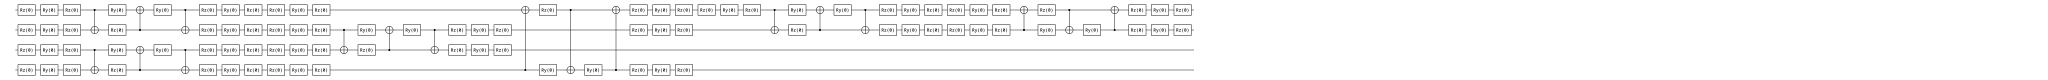

In [6]:
iters = 300 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function
ansatz = conv_SU4 # conv_Ry, conv_Ry2, conv_SU4

circ = build_QCNN(n, ansatz=ansatz)

p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

YaoPlots.plot(circ)

#### Run

In [7]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, optim, sig; output=false)

Initial: loss = 1.8648399558864561,tr_acc = 0.4, te_acc = 0.55
Final: loss = 0.0037161513032008403,tr_acc = 1.0, te_acc = 0.65


([5.845426758413508, 5.891238063867054, 3.8951317000646064, 5.721054229821944, 4.553189107739839, 5.2700562595468305, 4.761418849141843, 1.0255948992724389, 1.6697514425796964, 2.201029242373137  …  3.717700056390404, 4.002102073419474, 3.1740523771210762, 1.3531649120799585, 5.462966356441466, 3.3379654358429973, 4.166043780944811, 0.2373040025536383, 2.7056798021496804, 5.798084067589808], [1.8648399558864561, 1.4617591989744207, 1.0035171591525196, 0.7366462741238938, 0.5736150649396685, 0.4864467418695034, 0.45299791557379154, 0.3804414849934945, 0.3100854566926028, 0.2783602624275238  …  0.003814583106519122, 0.0038037202651003024, 0.0037928354007234696, 0.0037819299026266373, 0.0037710052393164837, 0.003760062957990143, 0.003749104683783497, 0.003738132118832088, 0.0037271470411340425, 0.0037161513032008403], [0.4, 0.45, 0.6, 0.8, 0.85, 0.95, 0.9, 0.95, 0.95, 0.95  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.55, 0.45, 0.45, 0.6, 0.65, 0.8, 0.85, 0.85, 0.8, 0.7  …  0.

#### Plot

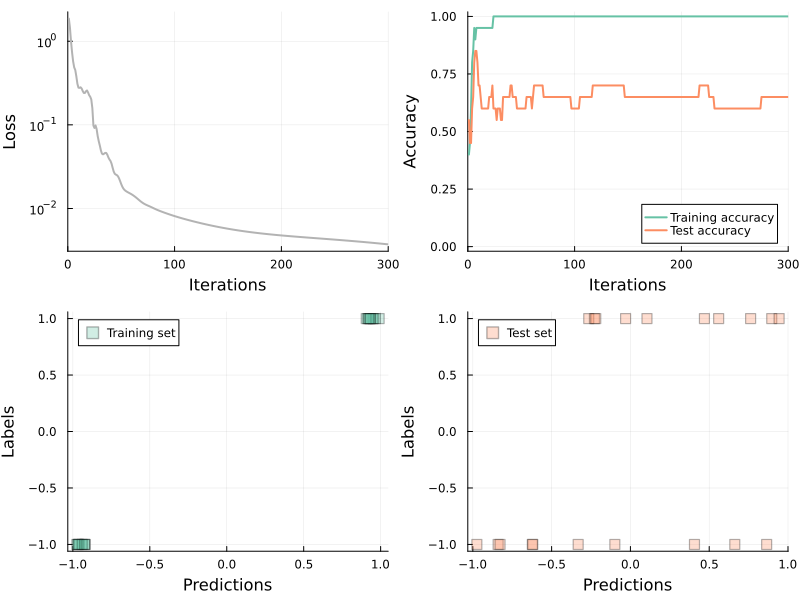

In [17]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))